실습 3.1 Text Classification with RNN model

# Dataset Load

In [1]:
with open('./Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)
    
words_list = [doc.strip().split() for doc in texts]
print(words_list[:2])

[['부산', '행', '때문', '너무', '기대하고', '봤'], ['한국', '좀비', '영화', '어색하지', '않게', '만들어졌', '놀랍']]


# Dataset Preprocessing

In [2]:
total_words = []
for words in words_list:
    total_words.extend(words)
    
from collections import Counter
c = Counter(total_words)

max_features = 10000
common_words = [ word for word, count in c.most_common(max_features)]
# 빈도를 기준으로 상위 10000개의 단어들만 선택

# 각 단어에 대해서 index 생성하기
words_dic = {}
for index, word in enumerate(common_words):
    words_dic[word]=index+1
    
# 각 문서를 상위 10000개 단어들에 대해서 index 번호로 표현하기
filtered_indexed_words = []
for review in words_list:
    indexed_words=[]
    for word in review:
        try:
            indexed_words.append(words_dic[word])
        except:
            pass
    filtered_indexed_words.append(indexed_words)

# Dataset Loader for Model

In [3]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
# X input padding
max_len = 40
X = sequence.pad_sequences(filtered_indexed_words, maxlen=max_len)
# y to one-hot category labeling
y_one_hot = to_categorical(labels)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2)

print(len(X_train))
print(len(X_test))

132307
33077


## Model Build
실습문제 3.1.1 Bidirectional LSTM을 구현하여 모델링을 완성하시오
from tensorflow.kears import layers

In [54]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop

model = Sequential()

model.add(layers.Embedding(max_features+1, 64, input_shape=(max_len, )))
'''
Bidirectional 파라미터
merge_mode: mode by which outputs of the forward and backward RNNs will be combined.
One of {sum/mul/concat(default)/ave/None} If None, the outputs will not be combined, they will be returned as a list.
'''
# return_sequence=True : whether to return the last output in the output sequence, or the full sequence
# return_state=True : whether to return the last state in addition to the output. 
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True), merge_mode='concat'))
model.add(layers.Bidirectional(layers.LSTM(16)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax')) #binary classification

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience=2)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 40, 64)            640064    
                                                                 
 bidirectional_34 (Bidirect  (None, 40, 64)            24832     
 ional)                                                          
                                                                 
 bidirectional_35 (Bidirect  (None, 32)                10368     
 ional)                                                          
                                                                 
 dense_27 (Dense)            (None, 16)                528       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 2)               

# Training

In [55]:
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2, callbacks=[es])

Epoch 1/5
827/827 [==============================] - 85s 95ms/step - loss: 0.4264 - accuracy: 0.7995 - val_loss: 0.2766 - val_accuracy: 0.8858
Epoch 2/5
827/827 [==============================] - 81s 98ms/step - loss: 0.2818 - accuracy: 0.8933 - val_loss: 0.3040 - val_accuracy: 0.8908
Epoch 3/5
827/827 [==============================] - 91s 110ms/step - loss: 0.2591 - accuracy: 0.9030 - val_loss: 0.2628 - val_accuracy: 0.8921
Epoch 4/5
827/827 [==============================] - 85s 103ms/step - loss: 0.2438 - accuracy: 0.9099 - val_loss: 0.2569 - val_accuracy: 0.8947
Epoch 5/5
827/827 [==============================] - 88s 107ms/step - loss: 0.2304 - accuracy: 0.9154 - val_loss: 0.2517 - val_accuracy: 0.8958


# Test

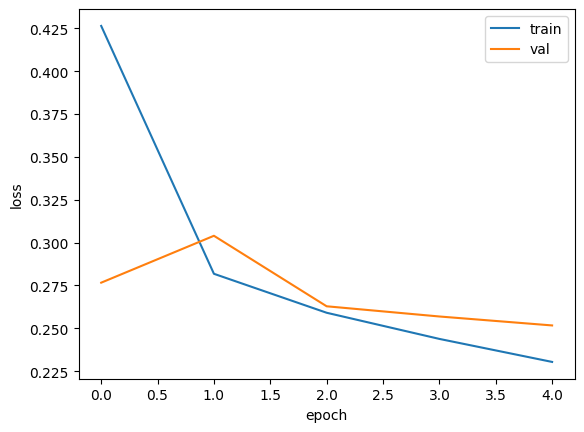

In [56]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [57]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

1034/1034 [==============================] - 15s 15ms/step - loss: 0.2520 - accuracy: 0.8965
Loss: 0.25201135873794556
Accuracy: 0.8965141773223877


# 실습 3.2 Machine Translation with Seq2Seq model

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import numpy as np
import os
import io
import re
import time

Dataset Preprocessing

In [2]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) # decompose string 's' into its base characters and combining characters using the Normalization Form D(NFD) scheme
                 if unicodedata.category(c)!= 'Mn') #checks if the character's category, obtained using unicodedata.category(), is not equal to 'Mn' 
#(Mn stands for 'Mark, Nonspacing' which includes diacritic marks like accents, umlauts, etc. So this condition effecively filters out all diacritic marks from the string)

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  # 단어와 단어 뒤에 오는 구두점(.)사이에 공백을 생성.
    # 예시: "he is a boy." => "he is a boy ."
    # 참고:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ",w)
  # (a-z, A-Z, ".", "?", "!", ",")을 제외한 모든 것을 공백으로 대체합니다.
  # w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.strip()

  # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
    # 문장에 start와 end 토큰을 추가합니다.
    
  w = '<start> ' + w + ' <end>'
  return w

In [3]:
# 1. 문장에 있는 억양을 제거합니다.
# 2. 불필요한 문자를 제거하여 문장을 정리합니다.
# 3. 다음과 같은 형식으로 문장의 쌍을 반환합니다: [영어, 스페인어]

def create_dataset(path, num_examples):
  ens = []
  spas = []
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  for l in lines[:num_examples]:
    word_pairs = [preprocess_sentence(w) for w in l.split('\t')[:2]]
    en, spa = word_pairs
    ens.append(en)
    spas.append(spa)
  return ens, spas

path_to_file = "kor.txt"
en, kor = create_dataset(path_to_file, None)

print(en[-1])
print(kor[-1])

print(len(en))
print(len(kor))

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> 의심의 여지 없이 세상에는 어떤 남자이든 정확히 딱 알맞는 여자와 결혼하거나 그 반대의 상황이 존재하지 . 그런데 인간이 수백 명의 사람만 알고 지내는 사이가 될 기회를 갖는다고 생각해 보면 , 또 그 수백 명 중 열여 명 쯤 이하만 잘 알 수 있고 , 그리고 나서 그 열여 명 중에 한두 명만 친구가 될 수 있다면 , 그리고 또 만일 우리가 이 세상에 살고 있는 수백만 명의 사람들만 기어

Tokenizing & Padding & Data Loading 

In [5]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='') #no characters are filtered out during tokenization
  lang_tokenizer.fit_on_texts(lang) #fits the tokenizer on the input text 'lang'. This step updates the internal vocabulary of the tokenizer based on the words(or tokens) present in the input text
  tensor = lang_tokenizer.texts_to_sequences(lang) #converts the text sequences in 'lang' into sequence of integers.(index according to the vocabulary learned by the previous step)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') # pads the sequences of integers in 'tensor' to ensure that they all have the same length
  return tensor, lang_tokenizer

In [6]:
def load_dataset(path, num_examples=None):
  # 전처리된 타겟 문장과 입력 문장 쌍을 생성합니다.
  targ_lang, inp_lang = create_dataset(path, num_examples)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [7]:
# 언어 데이터셋을 아래의 크기로 제한하여 훈련과 검증을 수행합니다.
num_examples = 10000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 타겟 텐서와 입력 텐서의 최대 길이를 계산합니다.
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

# 훈련 집합과 검증 집합을 80대 20으로 분리합니다.
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 훈련 집합과 검증 집합의 데이터 크기를 출력합니다.
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

4712 4712 1178 1178


In [8]:
print(max_length_targ, max_length_inp)

112 97


In [9]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))
            
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
8 ----> 톰이
2077 ----> 마실
12 ----> 수
44 ----> 있는
70 ----> 것은
745 ----> 오직
329 ----> 물
406 ----> 뿐이야
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
150 ----> water
10 ----> is
9 ----> the
178 ----> only
433 ----> thing
5 ----> tom
68 ----> will
303 ----> drink
3 ----> .
2 ----> <end>


Model Build for Training

In [13]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
# calculates the number of steps per epoch based on the length of the training input tensor and the chosen batch size.
# for defining the number of iterations per epoch during training
embedding_dim = 128
units = 512 # number of units in the recurrent units
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
#+1 is for accomodating the padding token.
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) #drop_remainder: ensures that any remaining samples that don't fit into a full batch are dropped.

In [18]:
#dataset 크기출력 ///왜 1차원???not 2차원?? dataset 오타.
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 97]), TensorShape([64, 112]))

## 인코더 모델과 디코더 모델 쓰기
어텐션(attention)을 가진 인코더-디코더 모델을 수행합니다. 어텐션(attention)은 TensorFlow Neural Machine Translation (seq2seq) tutorial에서 읽을 수 있습니다. 이 예제는 더 최신의 API 집합을 사용합니다. 이 노트북은 seq2seq 튜토리얼로부터 어텐션 방정식을 수행합니다. 아래의 다이어그램은 각각의 입력 단어가 어텐션 메커니즘에 의해 가중치가 할당된 모습입니다. 이러한 어텐션 메커니즘은 디코더가 문장에서 다음 단어를 예측하기 위해 사용됩니다. 아래의 그림과 공식은 Luong's paper에서 나온 어텐션 메커니즘의 예시입니다.

![image.png](attachment:c0952e5c-9c02-49c8-9117-f3fcf6b60447.png)![image.png](attachment:c0444d39-21a8-43e4-9792-86205b74b8ed.png)

이 튜토리얼은 인코더를 위해 Bahdanau 어텐션을 사용합니다. 단순화된 형태로 쓰기 전에 표기법을 아래와 같이 정의합니다:

FC = 완전 연결(Dense)층

EO = 인코더 결과

H = 은닉 상태(hidden state)

X = 디코더에 대한 입력
그리고 다음은 슈도코드입니다:

스코어(score)는 FC(tanh(FC(EO) + FC(H)))로 계산합니다.
어텐션 가중치는 softmax(score, axis = 1)로 계산합니다. 기본적으로 소프트맥스는 마지막 축을 적용하지만 스코어(score)의 형태가 (batch_size, max_length, hidden_size)이기 때문에 첫번째 축을 적용합니다. Max_length은 입력의 길이입니다. 각각의 입력에 가중치를 할당하려고 시도하기 때문에 소프트맥스는 그 축을 적용할 수 있습니다.
컨텍스트 벡터(context vector)는 sum(어텐션 가중치 * EO, axis = 1)로 계산합니다. 위와 같은 이유로 첫번째 축을 선택합니다.
임베딩 결과(embedding output)는 디코더 X에 대한 입력이 임베딩층을 통과한 결과입니다.
병합된 벡터(merged vector)는 concat(임베딩 결과, 컨텍스트 백터(context vector))와 같습니다.
그런 다음 병합된 벡터는 GRU에 주어집니다.

### 실습 문제 3.2.1 Encoder & Attention & Decoder 각 Class 이해하고 주석 달기

In [104]:
class Encoder(tf.keras.Model): #tf.keras.Model 클래스를 상속받아 Encoder Class 구현
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz): #4가지 파라미터를 이용하는 인코더 생성자 메소드
        # 1) vocab_size : 어휘 수(=input 랭귀지에서 unique한 토큰의 개수)
        # 2) embedding_dim : 임베딩 공간의 차원 값(각 단어는 해당 차원의 밀집벡터로 표현된다)
        # 3) enc_units : 인코더의 GRU 레이어 유닛(뉴런) 개수. (이는 인코더가 학습 및 표현할 수 있는 input 시퀀스의 용량을 결정한다)
        # 4) batch_sz : 배치 사이즈(학습 중 동시에 처리되는 시퀀스의 개수)
        
        super(Encoder, self).__init__() # 상위 클래스의 attribute와 메소드 받기 위해 생성자 호출 
        
        self.batch_sz = batch_sz # 배치 사이즈 설정
        self.enc_units = enc_units # 유닛 개수 설정
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # 임베딩 레이어 생성. 임베딩 레이어는
        # 토큰화된 input sequence를 고정 길이(embedding_dim)의 밀집 벡터로 바꾸어 준다. vocab_size와 embedding_dim 파라미터 필요
        
        # RNN 레이어(GRU) 생성 - basic RNN이 아닌 GRU를 사용해 long-range dependency를 학습할 수 있도록 한다
        self.gru = tf.keras.layers.GRU(self.enc_units, #GRU 레이어에서의 유닛 개수
                                   return_sequences=True, #GRU 레이어가 각 input sequence에 대한 전체 출력 시퀀스를 반환하도록 함  
                                   return_state=True, #GRU 레이어가 출력 뿐 아니라 마지막 상태를 출력하도록 함
                                   recurrent_initializer='glorot_uniform') #GRU 레이어의 가중치 초깃값을 Glorot uniform 으로 설정

        # GlorotUniform은 [-limit, limit]범위로 정규 분포를 기반으로 샘플 값 생성. limit = sqrt(6/(fan_in+fan_out))
        # fan_in은 가중치 텐서에 있는 입력층 유닛의 개수, fan_out은 출력층 유닛의 개수
    
    def call(self, x, hidden): #인코더 클래스의 call method 정의 - call()은 인코더모델이 호출될 때 릴행된다
        # x: input data(토큰화된 입력시퀀스)
        # hidden: GRU 레이어의 초기 은닉상태
        x = self.embedding(x) #입력 시퀀스를 임베딩 레이어에 통과시켜서 밀집 벡터 표현을 얻는다
        output, state = self.gru(x, initial_state = hidden) # 출력 시퀀스(output)와 마지막 은닉상태(state)를 계산한다(return_state=True로 설정했기 때문에 두 가지 값을 반환받음)
        return output, state #output과 state을 반환

    def initialize_hidden_state(self): # 새로운 batch를 처리하기 전 GRU 레이어의 hidden state를 초기화하는 메소드
        return tf.zeros((self.batch_sz, self.enc_units)) #(batch_sz, enc_units)의 shape을 가지는 텐서 0으로 초기화
  
class BahdanauAttention(tf.keras.layers.Layer): #tf.keras.layers.layer 클래스를 상속받아 
    def __init__(self, units): #생성자
        #생성자 파라미터 'units': 어텐션 메커니즘에서의 차원수(어텐션 스코어를 계산하기 위한 내부 Dense 레이어의 유닛 개수이다)
        
        super(BahdanauAttention, self).__init__() #상위 클래스의 생성자 호출
        
        self.W1 = tf.keras.layers.Dense(units) #units 값 개수만큼의 유닛을 가지는 Dense Layer 생성
        # W1 레이어는 attention score를 계산하기 전 쿼리 벡터들이 모두 같은 차원수를 가지도록 변환해주는 역할
        self.W2 = tf.keras.layers.Dense(units) #units 값 개수만큼의 유닛을 가지는 Dense Layer 생성
        # W2 레이어는 attention score를 계산하기 전 인코더 출력값들이 모두 같은 차원수를 가지도록 변환해주는 역할
        self.V = tf.keras.layers.Dense(1) #한 개의 unit을 갖는 Dense Layer 생성. 
        # V 레이어는 attention score를 계산 후 softmax을 취해 attention weight(어텐션 가중치)을 얻는 역할

    def call(self, query, values):
        #호출자 파라미터 query: 현재 time step에서의 쿼리 벡터. (seq2seq 모델에서 보통 디코더의 마지막 상태)
        #호출자 파라미터 values: value값(인코더에서 모든 time step에서의 output)
        
        #query 벡터에 time axis를 추가한다. 이는 query의 shape을 values의 shape과 맞추어 주기 위함
        query_with_time_axis = tf.expand_dims(query, 1)
        
        #어텐션 스코어 계산. 각각 W1,W2를 이용해 query와 values 값을 변환하고 그 둘을 더한 다음, 
        #hyperbolic tangent 활성화 함수를 적용한 결과를 V에 통과시킨다.
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        #softmax 함수(모든 가중치값의 합 1 되게끔)를 적용해 attention weights 계산. 
        attention_weights = tf.nn.softmax(score, axis=1)

        #attention weights와 values를 element-wise multiplication 통해 컨텍스트 벡터 계산.(weighted sum)
        context_vector = attention_weights * values

        #최종 컨텍스트 벡터를 얻기 위해 시간 축을 기준으로 가중치 값 합산. 이는 어텐션 메커니즘을 기반으로
        #입력 시퀀스에서 관련 정보를 캡처하는 벡터이다.
        #x = tf.constant([[1,1,1],[1,1,1]])
        #tf.reduce_sum(x) -> 6
        #tf.reduce_sum(x,axis=0) -> [2,2,2]
        #tf.reduce_sum(x,axis=1) -> [3,3]
        context_vector = tf.reduce_sum(context_vector, axis=1)

        #context vector와 attention weights를 반환.
        return context_vector, attention_weights
    
class Decoder(tf.keras.Model): #tf.keras.Model 클래스를 상속받아 Decoder Class 구현
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        # 1) vocab_size : 어휘 수(target 랭귀지의)
        # 2) embedding_dim : 임베딩 공간의 차원 값(target 언어에서의 각 단어는 해당 차원의 밀집벡터로 표현된다)
        # 3) dec_units : 디코더의 GRU 게이어 유닛(뉴런) 개수. 
        # 4) batch_sz : 배치 사이즈 

        super(Decoder, self).__init__() #상속받은 상위 클래스의 생성자 호출
        
        #attribute 값 설정
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        
        # 디코더 임베딩 레이어 생성.토큰화된 input sequence를 고정 길이(embedding_dim)의 밀집 벡터로 바꾸어 준다
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # RNN 레이어(GRU) 생성 - dec_units 개의 유닛을 가지고 return_sequence, return_state를 모두 True로 설정해 줌으로써
        # 각 input sequence에 대한 전체 출력 시퀀스, 디코더의 마지막 상태도 받도록.
        # GRU 레이어의 가중치 초깃값을 Glorot uniform 으로 설정
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        # Fully connected layer 생성 <- target vocabulary 상 확률 분포를 얻기 위함
        self.fc = tf.keras.layers.Dense(vocab_size)

        # BahdanauAttention 클래스의 인스턴스를 생성하여 어텐션 메커니즘을 이용해 디코더가 디코딩 과정에서 그때그때 다른
        # input sequence의 부분에 더 집중할 수 있도록 한다
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output): #호출자
        # x: 현재 time step의 input data(토큰화된 시퀀스)
        # hidden: 이전 time step의 GRU 레이어 은닉상태--처음은 인코더에서 마지막 hidden state
        # enc_output: input sequence의 정보를 담고 있는 인코더의 출력

        # Bahdanau Attention을 통해 context vector와 attention weights를 받는다
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        # input data x를 임베딩 레이어에 통과시켜서 밀집 벡터 표현을 얻는다
        x = self.embedding(x)
        # 디코더의 GRU의 입력으로 쓰기 위해 context vector와 x를 concatenate
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # x를 GRU 유닛에 통과시켜서 output sequence와 마지막 hidden state를 얻는다
        output, state = self.gru(x)
        #output 텐서를 reshape. reshape에 -1을 쓰면 다른 shape 값만 제대로 맞추도록 알아서 계산하라는 의미(텐서의 기존 요소들 모두 유지되도록)
        output = tf.reshape(output, (-1, output.shape[2]))
        #reshape 된 텐서를 fully connected layer에 통과시켜서 모든 타겟 어휘 상의 확률 분포(output logits)를 얻는다
        x = self.fc(output)
        # x(output logits), state(final hidden state), attention weights를 반환
        #x는 예측된 타겟 시퀀스를 생성하기 위해, state는 다음 time step에 전달되기 위해
        return x, state, attention_weights

### Encoder-Attention-Decoder 구현

In [105]:
vocab_inp_size, vocab_tar_size

(7961, 3211)

In [106]:
# encoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 샘플 입력
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

# encoder-decoder attention
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

# decoder
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Encoder output shape: (batch size, sequence length, units) (64, 97, 512)
Encoder Hidden state shape: (batch size, units) (64, 512)
Attention result shape: (batch size, units) (64, 512)
Attention weights shape: (batch_size, sequence_length, 1) (64, 97, 1)
Decoder output shape: (batch_size, vocab size) (64, 3211)


### Training Setup

In [107]:
optimizer = tf.keras.optimizers.Adam()
#Sparse Categorical Crossentropy 
#from_logits: whether y_pred is expected to be a logits tensor.
#ruduction: Type of reduction to apply to the loss. In almost all cases this should be 
#'sum_over_batch_size'. supported options are {sum/sum over batch size} or None
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # creates a mask where 'True' indicates the positions of non-padding tokens(where 'real' is not equal to 0),
    # and 'False' indicates the positions of padding tokens. 
    loss_ = loss_object(real, pred)
    # calculates the loss between the true labels(real) and the predicted labels(pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    # converts the mask to the same data type as the computed loss. This step is necessary to 
    # ensure that the mask can be multiplied element-wise with the loss.
    loss_ *= mask

    return tf.reduce_mean(loss_) #calculates the mean of the masked loss values

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training!

언어 모델 훈련하기
1. 인코더 결과와 인코더 은닉 상태(hidden state)를 반환하는 인코더를 통해서 입력을 전달합니다.
2. 인코더 결과, 인코더 은닉 상태(hidden state), 디코더 입력 (start 토큰)을 디코더에 전달합니다.
3. 전달 받은 값을 통해 디코더는 예측 값과 디코더 은닉 상태(hidden state)를 반환합니다.
4. 그 다음에 디코더 은닉 상태(hidden state)가 다시 모델에 전달되고 예측 값을 사용하여 손실을 계산합니다.
5. 디코더에 대한 다음 입력을 결정하기 위해서 교사 강요(teacher forcing)를 사용합니다.
6. 교사 강요(teacher forcing)는 타겟 단어가 디코더에 다음 입력으로 전달하기 위한 기술입니다.
7. 마지막 단계는 그레디언트(gradients)를 계산하여 이를 옵티마이저(optimizer)와 역전파(backpropagate)에 적용합니다.

In [108]:
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
      # encoder
      enc_output, enc_hidden = encoder(inp, enc_hidden)
      dec_hidden = enc_hidden
      
      # decoder
      dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

      # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)합니다.
      for t in range(1, targ.shape[1]):
          # enc_output를 디코더에 전달합니다.
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
          loss += loss_function(targ[:, t], predictions)

          # 교사 강요(teacher forcing)를 사용합니다.
          dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  #trainable_variables는 Encoder와 Decoder가 상속받은 클래스에 있는 속성
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [109]:
# 이 파트가 매우 오래걸림

EPOCHS = 3

for epoch in range(EPOCHS):
  start = time.time()
  
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step(inp, targ, enc_hidden)
      total_loss += batch_loss

      if batch % 10 == 0:
          print('Epoch {} / Batch {} / Loss {:.4f} / Time taken {} sec'.format(epoch + 1,
                                                                                batch,
                                                                                batch_loss.numpy(),
                                                                                time.time() - start))
  # 에포크가 2번 실행될때마다 모델 저장 (체크포인트)
  #if (epoch + 1) % 2 == 0:
  #    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} / Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
  print('Time taken for {} epoch {} sec\n'.format(epoch + 1,
                                                  time.time() - start))

Epoch 1 / Batch 0 / Loss 0.5508 / Time taken 31.897533655166626 sec
Epoch 1 / Batch 10 / Loss 0.3547 / Time taken 342.49861764907837 sec
Epoch 1 / Batch 20 / Loss 0.3687 / Time taken 653.7815310955048 sec
Epoch 1 / Batch 30 / Loss 0.3527 / Time taken 963.0116488933563 sec
Epoch 1 / Batch 40 / Loss 0.3608 / Time taken 1270.88419008255 sec
Epoch 1 / Batch 50 / Loss 0.3544 / Time taken 1579.9503571987152 sec
Epoch 1 / Batch 60 / Loss 0.3400 / Time taken 1885.4591567516327 sec
Epoch 1 / Batch 70 / Loss 0.3801 / Time taken 2191.03932595253 sec
Epoch 1 / Loss 0.3738
Time taken for 1 epoch 2251.5741336345673 sec

Epoch 2 / Batch 0 / Loss 0.3491 / Time taken 29.118820905685425 sec
Epoch 2 / Batch 10 / Loss 0.3296 / Time taken 321.31594371795654 sec
Epoch 2 / Batch 20 / Loss 0.3057 / Time taken 613.8220045566559 sec
Epoch 2 / Batch 30 / Loss 0.3029 / Time taken 910.4554595947266 sec
Epoch 2 / Batch 40 / Loss 0.3325 / Time taken 1200.2888412475586 sec
Epoch 2 / Batch 50 / Loss 0.3455 / Time take

In [28]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 나중에 어텐션 가중치를 시각화하기 위해 어텐션 가중치를 저장합니다.
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 예측된 ID를 모델에 다시 피드합니다.
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [83]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    #print('Input: %s' % (sentence))
    #print('Predicted translation: {}'.format(result))
    return result

In [ ]:
translate('hace mucho frio aqui.')

In [43]:
translate('톰이 마실 수 있는 것은 오직 물 뿐이야')

Input: <start> 톰이 마실 수 있는 것은 오직 물 뿐이야 <end>
Predicted translation: i don't don't be a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a 


### 실습 문제 3.2.2 - BLEU 스코어 구현하기
#### - Dataset Sample에서 Test 만들기
#### - BLEU Score 구현 
#### - 학습된 모델로 BLEU Score로 평가하기

In [ ]:
# 한국어 input 영어 target

In [68]:
# BLEU score 
import collections
import math

def ngram_counts(sentence, n):
  words = sentence.split()
  ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
  return collections.Counter(ngrams)
  #ngram 시퀀스마다 갯수를 센 Counter 딕셔너리 반환

#문장길이에 대한 과적합 보정
def brevity_penalty(pred, real):
  p_len = len(pred.split())
  r_len = len(real.split())
  if p_len > r_len:
    return 1
  else:
    return (p_len/r_len)
    #return math.exp(1-r_len/p_len) #min(1, pred len/real len)

def bleu_score(pred, real, weights=(0.25, 0.25, 0.25, 0.25)):
  bp = brevity_penalty(pred, real)
  ng = 1
  
  for i, weight in enumerate(weights, start=1):
    #i-gram 1부터 4까지
    gram_len = len(pred)-i+1 #분모(예측된 문장에서 n-gram 시퀀스의 길이)
    cnt = 0
    ngram_cnts_pred = ngram_counts(pred, i)
    ngram_cnts_real = ngram_counts(real, i)
    for key,value in ngram_cnts_pred.items():
      if key in ngram_cnts_real:
        # cnt += min(value, ngram_cnts_real[key]) 
        if value > ngram_cnts_real[key]:
          cnt += ngram_cnts_real[key] #Clipping
        else:
          cnt += value
    ng *= (cnt / gram_len)**weight
  
  return bp * ng


In [ ]:
#Test data로 성능 평가해보기(BLUE)
bleu = 0
for i, sample in enumerate(input_tensor_val):
  
  inp_sent = ''
  for w in sample:
    if w!=0:
      kw = inp_lang.index_word[w]
      if kw != '<start>' and kw != '<end>':
        inp_sent = inp_sent + kw +' '
  #print(inp_sent)

  pred_sent = translate(inp_sent).replace(' <end> ','')
  
  targ_sent = ''
  for w in target_tensor_val[i]:
    if w!=0:
      ew = targ_lang.index_word[w]
      if ew != '<start>' and ew != '<end>':
        targ_sent = targ_sent + ew + ' '
  #print(targ_sent)
  bleu += bleu_score(pred_sent, targ_sent)
  
  if i%100 == 0:
    print(f'{i+1}samples sampled')
  
print(f"총합산한 BLEU스코어: {bleu:.10f}")

In [92]:
print(f"{bleu:.6f}")

0.000000


In [98]:
print(f"{bleu*200:.60f}")

0.000000000000000000000000000000000000000000000000000000000000
